<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%200dB%20NOISE%20in%20TRIAX%20Dataset%20266128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [186]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK DCNN TRIAX/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db/F8_Normal_40db.mat


/tmp/ipython-input-1588734773.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['F8_Normal_40db']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db/F7_OR017_40db.mat
['F8_Normal_40db' 'F7_OR017_40db']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db/F1_IR007_40db.mat
['F8_Normal_40db' 'F7_OR017_40db' 'F1_IR007_40db']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db/F2_IR009_40db.mat
['F8_Normal_40db' 'F7_OR017_40db' 'F1_IR007_40db' 'F2_IR009_40db']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db/F3_IR013_40db.mat
['F8_Normal_40db' 'F7_OR017_40db' 'F1_IR007_40db' 'F2_IR009_40db'
 'F3_IR013_40db']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db/F4_IR017_40db.mat
['F8_Normal_40db' 'F7_OR017_40db' 'F1_IR007_40db' 'F2_IR009_40db'
 'F3_IR013_40db' 'F4_IR017_40db']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_40db/F6_OR013_40db.mat
['F8_Normal_40db' 'F7_OR017_40db' 'F1_IR007_40db' 'F2_IR009_40db'
 'F3_IR013_40db' 'F4_IR017_40db' 'F6_OR013_40db']
/content/drive/MyDrive/TRIAX_w

# Multi-Kernel Deep 1D-CNN

In [187]:
pip install tensorflow

In [188]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [189]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [190]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=100, activation='relu', input_shape=(X.shape[1],X.shape[2])))
cnn_model.add(Dropout(0.5))


cnn_model.add(Flatten())

cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
lr_history = []

class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        lr_history.append(lr)

lr_logger = LRLogger()


Number of output classes (no_classes): 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_77 (Conv1D)              │ (None, 515, 32)        │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 515, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 16480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 50)             │       824,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 827,690 (3.16 MB)

 Trainable params: 827,690 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [191]:
batch_size =200
epochs = 60
history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        shuffle=True,
                        callbacks=[lr_logger])


Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 959ms/step - accuracy: 0.1494 - loss: 2.0880 - val_accuracy: 0.2567 - val_loss: 1.9923
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2918 - loss: 1.8836 - val_accuracy: 0.3739 - val_loss: 1.6388
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4245 - loss: 1.5658 - val_accuracy: 0.4718 - val_loss: 1.4136
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5256 - loss: 1.3311 - val_accuracy: 0.5104 - val_loss: 1.2719
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5695 - loss: 1.1470 - val_accuracy: 0.5059 - val_loss: 1.2516
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6244 - loss: 1.0456 - val_accuracy: 0.5401 - val_loss: 1.1882
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6583 - loss: 0.9290 - val_accuracy: 0.5712 - val_loss: 1.1104
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7050 - loss: 0.8422 - val_accuracy: 0.5504 - val_loss: 1.118

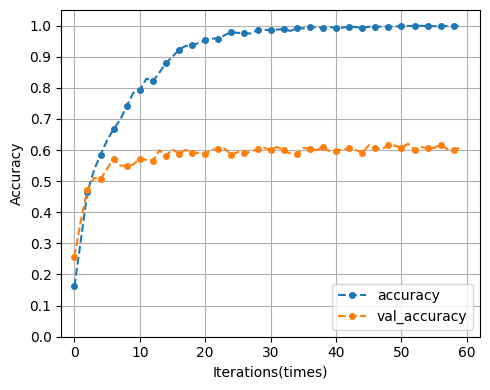

In [192]:
import numpy as np
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = np.arange(0, len(acc))

plt.figure(figsize=(5,4))

plt.plot(epochs_range, acc,
         linestyle='--',
         marker='o',
         markersize=4,
         markevery=2,
         label='accuracy')

plt.plot(epochs_range, val_acc,
         linestyle='--',
         marker='o',
         markersize=4,
         markevery=2,
         label='val_accuracy')

plt.xlabel('Iterations(times)')
plt.ylabel('Accuracy')

plt.xlim(-2, 62)
plt.ylim(0, 1.05)

plt.xticks(np.arange(0, 61, 10))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.grid(True)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [193]:
import numpy as np
from sklearn.metrics import classification_report

def inv_transform_result(y):
    y = y.argmax(axis=1)
    return encoder.inverse_transform(y)

# ===== 預測 =====
y_train_pred = cnn_model.predict(X_train)
y_test_pred  = cnn_model.predict(X_test)

Y_train_pred = inv_transform_result(y_train_pred)
Y_test_pred  = inv_transform_result(y_test_pred)

Y_train_true = inv_transform_result(y_train)
Y_test_true  = inv_transform_result(y_test)

# ===== Classification Report =====
print("Classification Report - Training Set:\n")
print(classification_report(Y_train_true, Y_train_pred, target_names=encoder.classes_))

print("\nClassification Report - Test Set:\n")
print(classification_report(Y_test_true, Y_test_pred, target_names=encoder.classes_))


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report - Training Set:

                precision    recall  f1-score   support

 F1_IR007_40db       1.00      1.00      1.00       207
 F2_IR009_40db       1.00      1.00      1.00       219
 F3_IR013_40db       1.00      1.00      1.00       207
 F4_IR017_40db       1.00      1.00      1.00       208
 F5_OR009_40db       1.00      1.00      1.00       198
 F6_OR013_40db       1.00      1.00      1.00       198
 F7_OR017_40db       1.00      1.00      1.00       190
F8_Normal_40db       1.00      1.00      1.00       145

      accuracy                           1.00      1572
     macro avg       1.00      1.00      1.00      1572
  weighted avg       1.00      1.00      1.00      1572


Classification Report - Test Set:

                precision    recall  f1-score   support

 F1_IR007_40db       0.96      0.89      0.93        84
 F2_IR009_40db       0.62      0.60      0.61        91
 F